In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator


In [2]:
train = pd.read_csv('cleaned_hm.csv')

In [3]:
train.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


In [4]:
demo = pd.read_csv('demographic.csv')
demo.head()

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


In [5]:
df_data = train[train['cleaned_hm'].notnull()]
len_count = df_data['cleaned_hm'].apply(lambda x: len(x.split()))
len_count.describe()

count    100535.000000
mean         18.298503
std          21.474146
min           2.000000
25%           9.000000
50%          14.000000
75%          21.000000
max        1179.000000
Name: cleaned_hm, dtype: float64

In [6]:
merge_data = pd.merge(df_data, demo, on='wid')
gender_data = merge_data[['cleaned_hm', 'gender']]
gender_data[gender_data['gender'] == "f"].head()

,cleaned_hm,gender
93,I went to the gym this morning and did yoga.,f
94,My husband passed his DOT physical and I don't...,f
95,I went to bible study tonight with special nee...,f
96,I lost 5 pounds which is awesome considering I...,f
97,My husband started working more after having h...,f


In [7]:
gender_data[gender_data['gender'] == "m"].head()

,cleaned_hm,gender
0,I went on a successful date with someone I fel...,m
1,I played a new game that was fun and got to en...,m
2,I listened to some music and heard an entire a...,m
3,Went to see a movie with my friend,m
4,"Played guitar, learning a song on it",m


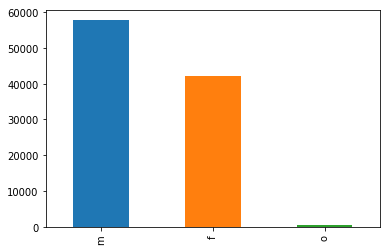

In [8]:
gender_data.gender.value_counts().plot(kind='bar')

In [9]:
gender_bin_data = gender_data[(gender_data['gender'] == 'm') | (gender_data['gender'] == 'f')]

print("Happy moments written by male/female: {}".format(gender_bin_data['cleaned_hm'].size))

Happy moments written by male/female: 99759


In [10]:
gender_bin_data = gender_bin_data.assign(gender_bin=(np.where(gender_bin_data['gender']=='m', 1, 0)))

gender_bin_data.head()

,cleaned_hm,gender,gender_bin
0,I went on a successful date with someone I fel...,m,1
1,I played a new game that was fun and got to en...,m,1
2,I listened to some music and heard an entire a...,m,1
3,Went to see a movie with my friend,m,1
4,"Played guitar, learning a song on it",m,1


In [11]:
hm_size = gender_bin_data['cleaned_hm'].size
num_train_hm = int(0.7 * gender_bin_data['cleaned_hm'].size)

train_hm = gender_bin_data.iloc[0:num_train_hm]
test_hm = gender_bin_data.iloc[num_train_hm:hm_size]
test_hm = test_hm.reset_index(drop=True)

test_hm.head()


,cleaned_hm,gender,gender_bin
0,"I started to walk more around the office, meet...",f,0
1,I bought my mom a bonsai tree for Mother's Day...,f,0
2,I was able to plan out the next two months as ...,f,0
3,I had dinner with coworkers who were leaving e...,f,0
4,I bought presents for my nieces for their home...,f,0


In [12]:
def clean_up_texts(hm_data):
    prepro_hm = []
    stops = set(stopwords.words("english"))
    for i in range(0, hm_data['cleaned_hm'].size):
        # Remove non-english words, including punctuations and numbers
        letters = re.sub("[^a-zA-Z]", " ", str(hm_data.iloc[i]['cleaned_hm']))

        # Convert all words to lower case
        lower_words = letters.lower()

        # Tokenize the sentences
        tokens = lower_words.split()

        # Reconstruct the processed tokens into a string
        prepro_string = " ".join(tokens)

        prepro_hm.append(prepro_string)
        
    return prepro_hm
    


In [13]:
prepro_train = clean_up_texts(train_hm)
prepro_test = clean_up_texts(test_hm)
print("Texts cleaned up! \n")

Texts cleaned up! 



In [14]:
prepro_train[:10]

['i went on a successful date with someone i felt sympathy and connection with',
 'i played a new game that was fun and got to enjoy the mechanics of it',
 'i listened to some music and heard an entire album i hadn t heard more than once before',
 'went to see a movie with my friend',
 'played guitar learning a song on it',
 'talked to my romantic prospect',
 'i played a game for about half an hour',
 'i discovered another album i hadn t heard by a band i recently got into',
 'i talked to the girl i m dating about some interesting topics',
 'i was happy when my son got marks in his examination']

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
vectorizer = CountVectorizer(analyzer = "word")
features_train_hm = vectorizer.fit_transform(prepro_train)
tf_transformer = TfidfTransformer(use_idf=False).fit(features_train_hm)
features_train_hm_tf = tf_transformer.transform(features_train_hm)
train_array_hm = features_train_hm_tf.toarray()
print("Dimension of the training data: {}".format(train_array_hm.shape))

Dimension of the training data: (69831, 20737)


In [19]:
features_test_hm = vectorizer.transform(prepro_test)
tf_transformer = TfidfTransformer(use_idf=False).fit(features_test_hm)
features_test_hm_tf = tf_transformer.transform(features_test_hm)
test_array_hm = features_test_hm_tf.toarray()
print("Dimension of the test data: {}".format(test_array_hm.shape))

Dimension of the test data: (29928, 20737)


In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
clf = SGDClassifier(loss="log", penalty="l1", max_iter=10)
clf = clf.fit(train_array_hm, train_hm['gender_bin'])
predictions = clf.predict(test_array_hm)
print(metrics.accuracy_score(test_hm['gender_bin'], predictions))

/Users/lumin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.62085672280139


In [22]:
parent_data = merge_data[['cleaned_hm', 'parenthood']]
parent_data.head()

,cleaned_hm,parenthood
0,I went on a successful date with someone I fel...,n
1,I played a new game that was fun and got to en...,n
2,I listened to some music and heard an entire a...,n
3,Went to see a movie with my friend,n
4,"Played guitar, learning a song on it",n


In [23]:
parent_data.describe()

,cleaned_hm,parenthood
count,100535,100457
unique,96486,2
top,I WENT TO TEMPLE,n
freq,120,60937


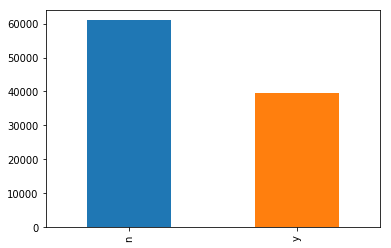

In [24]:
parent_data.parenthood.value_counts().plot(kind='bar')

In [25]:
parent_data[parent_data['parenthood'] == "n"][:5]

,cleaned_hm,parenthood
0,I went on a successful date with someone I fel...,n
1,I played a new game that was fun and got to en...,n
2,I listened to some music and heard an entire a...,n
3,Went to see a movie with my friend,n
4,"Played guitar, learning a song on it",n


In [26]:
parent_bin_data = parent_data[(parent_data['parenthood'] == 'y') | (parent_data['parenthood'] == 'n')]

print("Happy moments written by people who has/doesn't has kids: {}".format(parent_bin_data['cleaned_hm'].size))

Happy moments written by people who has/doesn't has kids: 100457


In [27]:
parent_bin_data = parent_bin_data.assign(parent_bin=(np.where(parent_bin_data['parenthood']=='y', 1, 0)))

parent_bin_data[:5]

,cleaned_hm,parenthood,parent_bin
0,I went on a successful date with someone I fel...,n,0
1,I played a new game that was fun and got to en...,n,0
2,I listened to some music and heard an entire a...,n,0
3,Went to see a movie with my friend,n,0
4,"Played guitar, learning a song on it",n,0


In [28]:
parenthm_size = parent_bin_data['cleaned_hm'].size
num_train_parenthm = int(0.7 * parent_bin_data['cleaned_hm'].size)

train_parenthm = parent_bin_data.iloc[0:num_train_parenthm]
test_parenthm = parent_bin_data.iloc[num_train_parenthm:parenthm_size]
test_parenthm = test_parenthm.reset_index(drop=True)

test_parenthm.head()

,cleaned_hm,parenthood,parent_bin
0,My fiance bought me 2 bottles of wine.,y,1
1,I found a note my deceased mother had written ...,y,1
2,"I saw my niece for the first time, ever.",y,1
3,My fiance made me a pair of crown headphones.,y,1
4,My fiance cooked a full course dinner for me,y,1


In [29]:
prepro_train_parent = clean_up_texts(train_parenthm)
prepro_test_parent = clean_up_texts(test_parenthm)
print("Texts cleaned up! \n")

Texts cleaned up! 



In [30]:
prepro_train_parent[:10]

['i went on a successful date with someone i felt sympathy and connection with',
 'i played a new game that was fun and got to enjoy the mechanics of it',
 'i listened to some music and heard an entire album i hadn t heard more than once before',
 'went to see a movie with my friend',
 'played guitar learning a song on it',
 'talked to my romantic prospect',
 'i played a game for about half an hour',
 'i discovered another album i hadn t heard by a band i recently got into',
 'i talked to the girl i m dating about some interesting topics',
 'i was happy when my son got marks in his examination']

In [31]:
vectorizer = CountVectorizer(analyzer = "word")
features_train_hm = vectorizer.fit_transform(prepro_train_parent)
tf_transformer = TfidfTransformer(use_idf=False).fit(features_train_hm)
features_train_hm_tf = tf_transformer.transform(features_train_hm)
train_array_hm = features_train_hm_tf.toarray()
print("Dimension of the training data: {}".format(train_array_hm.shape))

Dimension of the training data: (70319, 20817)


In [32]:
features_test_hm = vectorizer.transform(prepro_test_parent)
tf_transformer = TfidfTransformer(use_idf=False).fit(features_test_hm)
features_test_hm_tf = tf_transformer.transform(features_test_hm)
test_array_hm = features_test_hm_tf.toarray()
print("Dimension of the test data: {}".format(test_array_hm.shape))

Dimension of the test data: (30138, 20817)


In [33]:
clf = SGDClassifier(loss="log", penalty="l1", max_iter=10)
clf = clf.fit(train_array_hm, train_parenthm['parent_bin'])
predictions = clf.predict(test_array_hm)
print(metrics.accuracy_score(test_parenthm['parent_bin'], predictions))

/Users/lumin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.7183622005441636


In [34]:
vocab_parent = vectorizer.get_feature_names()

vocab_parent[:20]

['aa',
 'aaa',
 'aadat',
 'aadhaar',
 'aadhar',
 'aagra',
 'aakshayatriya',
 'aas',
 'aashwin',
 'ab',
 'aback',
 'abacus',
 'abandon',
 'abandoned',
 'abasket',
 'abating',
 'abbott',
 'abby',
 'abc',
 'abcs']

In [36]:
from sklearn.linear_model import LogisticRegression

logi_model = LogisticRegression()
logi_model.fit(train_array_hm, train_parenthm['parent_bin'])

logi_model.score(train_array_hm, train_parenthm['parent_bin'])

/Users/lumin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7321776475774684

In [37]:
feature_names_parent = vocab_parent
coefficients_parent = logi_model.coef_.tolist()[0]
weight_parentdf = pd.DataFrame({'Word': feature_names_parent,
                          'Coeff': coefficients_parent})
weight_parentdf = weight_parentdf.sort_values(['Coeff', 'Word'], ascending=[0, 1])
weight_parentdf.head(n=20)


,Word,Coeff
4674,daughter,12.529862
17084,son,11.424060
9993,kids,8.683290
4675,daughters,5.179837
3204,children,5.167103
7873,granddaughter,4.945775
3197,child,4.932056
17098,sons,4.742522
9986,kid,4.252552
8867,husband,4.059655


In [38]:
weight_parentdf.tail(n=10)


,Word,Coeff
2897,cats,-2.019970
2206,boyfriend,-2.043335
14760,recently,-2.115590
7414,future,-2.125239
7853,graduate,-2.190330
13963,precious,-2.271958
13071,partner,-2.378295
15609,roommate,-3.102773
19363,uncle,-3.316983
7661,girlfriend,-4.944808


In [39]:
total_bin_data = merge_data[(merge_data['parenthood'] == 'y') 
                            | (merge_data['parenthood'] == 'n') 
                            | (merge_data['marital'] == 'single') 
                            | (merge_data['marital'] == 'married') 
                            | (merge_data['marital'] == 'divorced') 
                            | (merge_data['marital'] == 'separated') 
                            | (merge_data['marital'] == 'widowed') 
                            | (merge_data['gender'] == 'm') 
                            | (merge_data['gender'] == 'f') ]

In [40]:
total_bin_data = total_bin_data[['wid','cleaned_hm','gender','marital','parenthood']]
total_bin_data.head()

,wid,cleaned_hm,gender,marital,parenthood
0,2053,I went on a successful date with someone I fel...,m,single,n
1,2053,I played a new game that was fun and got to en...,m,single,n
2,2053,I listened to some music and heard an entire a...,m,single,n
3,2053,Went to see a movie with my friend,m,single,n
4,2053,"Played guitar, learning a song on it",m,single,n


In [41]:
total_bin_data['statue_bin'] = np.nan
total_bin_data[:5]

,wid,cleaned_hm,gender,marital,parenthood,statue_bin
0,2053,I went on a successful date with someone I fel...,m,single,n,NaN
1,2053,I played a new game that was fun and got to en...,m,single,n,NaN
2,2053,I listened to some music and heard an entire a...,m,single,n,NaN
3,2053,Went to see a movie with my friend,m,single,n,NaN
4,2053,"Played guitar, learning a song on it",m,single,n,NaN


In [42]:
#df = pd.DataFrame(total_bin_data)
for i in range(0, total_bin_data['statue_bin'].size):
    if total_bin_data.iloc[i]['gender'] == 'm': 
        if total_bin_data.iloc[i]['marital'] == 'married': 
            if total_bin_data.iloc[i]['parenthood'] == 'y':
                total_bin_data.loc[i,'statue_bin'] = '0'
            else:
                total_bin_data.loc[i,'statue_bin'] = '1'
        if total_bin_data.iloc[i]['marital'] == 'single' or total_bin_data.iloc[i]['marital'] == 'divorced' or total_bin_data.iloc[i]['marital'] == 'widowed'or total_bin_data.iloc[i]['marital'] == 'separated':
            if total_bin_data.iloc[i]['parenthood'] == 'y':
                total_bin_data.loc[i,'statue_bin'] = '2'
            else :
                total_bin_data.loc[i,'statue_bin'] = '3'
    if total_bin_data.iloc[i]['gender'] == 'f': 
        if total_bin_data.iloc[i]['marital'] == 'married': 
            if total_bin_data.iloc[i]['parenthood'] == 'y':
                total_bin_data.loc[i,'statue_bin'] = '4'
            else :
                total_bin_data.loc[i,'statue_bin'] = '5'
        if total_bin_data.iloc[i]['marital'] == 'single' or total_bin_data.iloc[i]['marital'] == 'divorced' or total_bin_data.iloc[i]['marital'] == 'widowed' or total_bin_data.iloc[i]['marital'] == 'separated':
            if total_bin_data.iloc[i]['parenthood'] == 'y':
                total_bin_data.loc[i,'statue_bin'] = '6'
            else :
                total_bin_data.loc[i,'statue_bin'] = '7'
    if total_bin_data.iloc[i]['gender'] != 'f' and total_bin_data.iloc[i]['gender'] != 'm': 
        total_bin_data.loc[i,'statue_bin'] = '8'

In [43]:
total_bin_data[total_bin_data['statue_bin']== '1'][:10]

,wid,cleaned_hm,gender,marital,parenthood,statue_bin
1158,402.0,Going to the mountains and hiking the trail to...,m,married,n,1
1159,402.0,Taking my dog for a walk and having a conversa...,m,married,n,1
1160,402.0,Meeting up with my girlfriend at the park and ...,m,married,n,1
1161,402.0,Went out for a walk and had a great talk with ...,m,married,n,1
1162,402.0,Exercised and managed to beat my record of run...,m,married,n,1
1163,402.0,Bought a few pounds of crab legs and cooked th...,m,married,n,1
1164,402.0,Went downstairs and cuddled with my cat on the...,m,married,n,1
1165,402.0,Made a big breakfast of eggs bacon on a bagel ...,m,married,n,1
1166,402.0,Going out for my daily jog and not getting tir...,m,married,n,1
1167,402.0,Having a nice phone call with my mother for an...,m,married,n,1


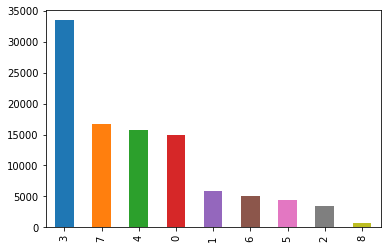

In [44]:
total_bin_data.statue_bin.value_counts().plot(kind='bar')

In [45]:
total_bin_data = total_bin_data[['cleaned_hm','statue_bin']]
total_bin_data = total_bin_data[(total_bin_data['statue_bin'] == '0') 
                                | (total_bin_data['statue_bin'] == '1') 
                                | (total_bin_data['statue_bin'] == '2') 
                                | (total_bin_data['statue_bin'] == '3') 
                                | (total_bin_data['statue_bin'] == '4') 
                                | (total_bin_data['statue_bin'] == '5') 
                                | (total_bin_data['statue_bin'] == '6') 
                                | (total_bin_data['statue_bin'] == '7') 
                                | (total_bin_data['statue_bin'] == '8') ]
total_bin_data.describe()

,cleaned_hm,statue_bin
count,100357,100383
unique,96311,9
top,I WENT TO TEMPLE,3
freq,120,33431


In [46]:
total_size = total_bin_data['cleaned_hm'].size
num_total_hm = int(0.7 * total_bin_data['cleaned_hm'].size)

train_totalhm = total_bin_data.iloc[0:num_total_hm]
test_totalhm = total_bin_data.iloc[num_total_hm:total_size]
test_totalhm = test_totalhm.reset_index(drop=True)

test_totalhm.head()

,cleaned_hm,statue_bin
0,I'm drinking a delicious beer at home.,6
1,I was able to go out and spend an evening with...,5
2,My daughter and I watched a tv show when we go...,5
3,I discovered my 1 year old niece learned how t...,5
4,I want to a romantic dinner with my man and ...,7


In [47]:
prepro_totaltrain = clean_up_texts(train_totalhm)
prepro_totaltest = clean_up_texts(test_totalhm)
print("Texts cleaned up! \n")

Texts cleaned up! 



In [48]:
vectorizer = CountVectorizer(analyzer = "word")
features_train_hm = vectorizer.fit_transform(prepro_totaltrain)
tf_transformer = TfidfTransformer(use_idf=False).fit(features_train_hm)
features_train_hm_tf = tf_transformer.transform(features_train_hm)
train_array_hm = features_train_hm_tf.toarray()
print("Dimension of the training data: {}".format(train_array_hm.shape))

Dimension of the training data: (70268, 20813)


In [49]:
features_test_hm = vectorizer.transform(prepro_totaltest)
tf_transformer = TfidfTransformer(use_idf=False).fit(features_test_hm)
features_test_hm_tf = tf_transformer.transform(features_test_hm)
test_array_hm = features_test_hm_tf.toarray()
print("Dimension of the test data: {}".format(test_array_hm.shape))

Dimension of the test data: (30115, 20813)


In [50]:
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10)
clf = clf.fit(train_array_hm, train_totalhm['statue_bin'])
predictions = clf.predict(test_array_hm)
print(metrics.accuracy_score(test_totalhm['statue_bin'], predictions))

/Users/lumin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.29473684210526313


In [51]:
clf = SGDClassifier(loss="log", penalty="l1", max_iter=10)
clf = clf.fit(train_array_hm, train_totalhm['statue_bin'])
predictions = clf.predict(test_array_hm)
print(metrics.accuracy_score(test_totalhm['statue_bin'], predictions))

/Users/lumin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.3105097127677237


In [52]:
logi_model = LogisticRegression()
logi_model.fit(train_array_hm, train_totalhm['statue_bin'])

logi_model.score(train_array_hm, train_totalhm['statue_bin'])

/Users/lumin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lumin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.4586582797290374

In [54]:
predictions = logi_model.predict(test_array_hm)
print(metrics.accuracy_score(test_totalhm['statue_bin'], predictions))

0.2938070728872655


In [55]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5)
clf = clf.fit(train_array_hm, train_totalhm['statue_bin'])
predictions = clf.predict(test_array_hm)
print(metrics.accuracy_score(test_totalhm['statue_bin'], predictions))

0.2766063423543085


In [56]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
clf = MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
clf = clf.fit(train_array_hm, train_totalhm['statue_bin'])
predictions = clf.predict(test_array_hm)
print(metrics.accuracy_score(test_totalhm['statue_bin'], predictions))

0.29473684210526313
